# Emotiv - Artifact removal and classification improvement

Use the artifact removal tool to see if there are any improvements in classification rate of the SSVEP trials

In [1]:
#%% Import libraries
import os
import mne
import sys
import time
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib.collections as collections
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
sys.path.append("..") # Adds higher directory to python modules path.
from Functions import artifact_removal_tools as art
from Functions import eeg_preprocessing
from Functions import eeg_quality_index
from IPython.display import clear_output

## Import data

In [2]:
# File names to import
files = ['SSVEP_10Hz_LF_Mar23_EPOCX_126787_2021.03.23T17.18.27.06.00.edf', 'SSVEP_10Hz_OKB_Mar22_EPOCX_126582_2021.03.22T17.42.37.06.00.edf',
        'SSVEP_17Hz_LF_Mar23_EPOCX_126787_2021.03.23T17.20.48.06.00.edf', 'SSVEP_17Hz_OKB_Mar22_EPOCX_126582_2021.03.22T17.45.11.06.00.edf']
n_files = len(files)    

# Determine data folder
notebook_dir = os.getcwd()              # Notebook directory
os.chdir('..')                          # Move one folder up
main_dir = os.getcwd()                  # Main project directory
data_folder = main_dir + "\\Data"       # Data folder
os.chdir(notebook_dir)                  # Return to notebook directory

# EEG channel indices
ch_start = 4    # Channel start index [n]
ch_end = 18     # Channel end index [n]
eeg_ch_index = np.arange(ch_start, ch_end)

# Preallocate data
eeg_raw = [None] * n_files
srate = [None] * n_files
chans = [None] * n_files

for i,f in enumerate(files):
    temp_data = mne.io.read_raw_edf(data_folder+'\\'+f, verbose=False)
    eeg_raw[i] = temp_data.get_data(eeg_ch_index.tolist())
    srate[i] = temp_data.info['sfreq']
    chans[i] = temp_data.info['ch_names'][slice(ch_start, ch_end)]

## Artifact removal tool - windowed implementation


In [3]:
# Filter settings
f_type = 'band'
fc = [1,60]     # Cut-off frequencies [Hz]
order = 4       # Filter order [n]

# Artifact removal tool settings
w_length = 0.9  # Window length [sec]
n_clusters = 10 # Number of clusters for k_means [n]

# Preallocate data
eeg_raw_w = [None] * n_files    # RAW EEG
eeg_pre_w = [None] * n_files    # Preprocessed EEG
eeg_art_w = [None] * n_files    # Artifact removed EEG
exec_time = [None] * n_files    # Execution times

w_art = 1.5   # Windows to process data, to simulate real-time [sec]

for i in range(n_files):
    temp_eeg = eeg_raw[i]
    n_chans = np.size(temp_eeg,0)

    # Reshape temp_eeg in windows of length w_art
    len_temp_eeg = np.size(temp_eeg,1)  # Length of trial [samples]
    len_window = int(w_art * srate[i])  # Length of window [samples]
    
    # - Trim data to full size windows
    if len_temp_eeg % len_window:
        trim = np.floor(len_temp_eeg/len_window) * len_window
        temp_eeg = temp_eeg[:,0:int(trim)]
        len_temp_eeg = np.size(temp_eeg,-1)  # Length of trial [samples]

    n_windows = int(np.floor(len_temp_eeg/len_window))
    exec_time[i] = np.zeros((n_windows,3))
    eeg_raw_w[i] = np.reshape(temp_eeg, [-1, n_chans, len_window])
    temp_pre_tensor = np.zeros_like(eeg_raw_w[i])
    temp_art_tensor = np.zeros_like(eeg_raw_w[i])

    for w in range(n_windows):
        exec_time[i][w,0] = time.time()
        temp_pre_tensor[w,:,:] = eeg_preprocessing.filter(f_type, eeg_raw_w[i][w,:,:], fc, srate[i], order)
        exec_time[i][w,1] = time.time()
        temp_art_tensor[w,:,:],_,_ = art.remove_eyeblinks_cpu(temp_pre_tensor[w,:,:], srate[i], w_length, n_clusters)
        exec_time[i][w,2] = time.time()

    eeg_pre_w[i] = temp_pre_tensor
    eeg_art_w[i] = temp_art_tensor

## Linear Discriminant Analysis Classification - PSD
 
- Compare raw, preprocessed and artifact removed data
- Compute the Power Spectral Density (PSD) to each window, of data, assign labels to the data and perform LDA classification

### Power Spectral Densities

In [4]:
freq = [None] * n_files
psd_raw = [None] * n_files
psd_pre = [None] * n_files
psd_art = [None] * n_files

# Calculate Power Spectral Densities
for f,file in enumerate(files):
    [freq[f], psd_raw[f]] = signal.welch(eeg_raw_w[f], window=np.ones(len_window), fs=srate[f])
    [_, psd_pre[f]] = signal.welch(eeg_pre_w[f], window=np.ones(len_window), fs=srate[f])
    [_, psd_art[f]] = signal.welch(eeg_art_w[f], window=np.ones(len_window), fs=srate[f])

### Area under the curve

Calculate the area under the curve for multiple harmonics

In [5]:
# Settings
ssvep_freqs = [10, 10, 17, 17]  # SSVEP Frequencies [Hz]
ssvep_band = 1          # SSVEP band +/- [Hz]
ssvep_harmonics = 3     # Number of harmonics to calculate AUC

# Preallocate variables
auc_raw = [None] * n_files
auc_pre = [None] * n_files
auc_art = [None] * n_files

for f,file in enumerate(files):
    windows = np.size(psd_raw[f],0)
    auc_raw[f] = np.zeros((n_chans, windows))
    auc_pre[f] = np.zeros((n_chans, windows))
    auc_art[f] = np.zeros((n_chans, windows))

    for w in range(windows):
        auc_raw[f][:,w] = eeg_preprocessing.auc(psd_raw[f][w,:,:], srate[f], ssvep_freqs[f], ssvep_band, ssvep_harmonics)
        auc_pre[f][:,w] = eeg_preprocessing.auc(psd_pre[f][w,:,:], srate[f], ssvep_freqs[f], ssvep_band, ssvep_harmonics)
        auc_art[f][:,w] = eeg_preprocessing.auc(psd_art[f][w,:,:], srate[f], ssvep_freqs[f], ssvep_band, ssvep_harmonics)

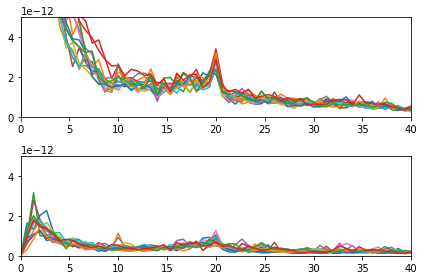

In [20]:
fig, ax = plt.subplots(2,1)
x_lim = [0,40]
y_lim = [0, 5e-12]
file = 0

ax[0].plot(freq[0], np.mean(psd_raw[file], 0).T)
ax[0].set_xlim(x_lim)
ax[0].set_ylim(y_lim)

ax[1].plot(freq[0], np.mean(psd_art[file], 0).T)
ax[1].set_xlim(x_lim)
ax[1].set_ylim(y_lim)
plt.tight_layout()

### Labels and Reshape

- Create labels for variables and reshape PSD into `[window, features]` matrices, where `features = n_channels * PSD_samples` 
- Organize and randomize 10 and 17 Hz windows per subject

In [7]:
# Create labels 
labels = [None] * n_files

for f,file in enumerate(files):
    file_str = file.split('_')
    ssvep_freq = int(file_str[1][0:2])
    labels[f] = np.ones(np.size(eeg_raw_w[f],0)) * ssvep_freq

# Reshape data to epochs (i.e., windows)
# - Each epoch[s] corresponds to a subject
subjects = 2
epochs_raw = [None] * subjects
epochs_pre = [None] * subjects
epochs_art = [None] * subjects


for epoch in range(2): 
    windows_10 = np.size(psd_raw[epoch],0)
    windows_17 = np.size(psd_raw[epoch+2],0)
    windows_raw =  windows_10 + windows_17
    features_raw = np.size(psd_raw[epoch],1)*np.size(psd_raw[epoch],2)
    epochs_raw[epoch] = np.zeros((windows_raw, features_raw+1))
    epochs_raw[epoch][:,0] = np.append(labels[epoch], labels[epoch+2])
    epochs_raw[epoch][:,1:] = np.append(np.reshape(psd_raw[epoch], [windows_10, -1]), np.reshape(psd_raw[epoch+2], [windows_17, -1]), axis=0)

    epochs_pre[epoch] = np.zeros((windows_raw, features_raw+1))
    epochs_pre[epoch][:,0] = np.append(labels[epoch], labels[epoch+2])
    epochs_pre[epoch][:,1:] = np.append(np.reshape(psd_pre[epoch], [windows_10, -1]), np.reshape(psd_pre[epoch+2], [windows_17, -1]), axis=0)

    epochs_art[epoch] = np.zeros((windows_raw, features_raw+1))
    epochs_art[epoch][:,0] = np.append(labels[epoch], labels[epoch+2])
    epochs_art[epoch][:,1:] = np.append(np.reshape(psd_art[epoch], [windows_10, -1]), np.reshape(psd_art[epoch+2], [windows_17, -1]), axis=0)

## Randomize and perform LDA

Randomize order of samples and perform LDA for classification

In [52]:
train_percentage = 0.8
test_percentage = 1-train_percentage

def randomize_order(len_samples):
    random_array = np.arange(len_samples)
    np.random.shuffle(random_array)
    return random_array

total_samples = np.size(epochs_raw[0],0)
rand_order = randomize_order(total_samples)
train_index = int(np.floor(total_samples*train_percentage))
test_index = int(np.floor(total_samples*test_percentage))
lda_data = np.squeeze(epochs_art[0][rand_order,:])

clf = LinearDiscriminantAnalysis()
clf.fit(lda_data[0:train_index,1:], lda_data[0:train_index,0])
predict_score = clf.score(lda_data[train_index+1:-1,1:], lda_data[train_index+1:-1,0])
y_pred = clf.predict(lda_data[train_index+1:,1:])
y_true = lda_data[train_index+1:,0]
cm = confusion_matrix(y_true, y_pred)

print(f'Prediction score = {predict_score}')
print(f'Confusion Matrix:\n{cm}')

Prediction score = 0.4583333333333333
Confusion Matrix:
[[ 8  4]
 [10  3]]


## Linear Discriminant Analysis - AUC

Perform LDA on the AUC data

In [76]:
subjects = 2
auc_lda_raw = [None] * subjects
auc_lda_pre = [None] * subjects
auc_lda_art = [None] * subjects

# Create variables to train and test LDA
for epoch in range(subjects): 
    windows_10 = np.size(auc_raw[epoch],1)
    windows_17 = np.size(auc_raw[epoch+2],1)
    windows_raw =  windows_10 + windows_17
    features_raw = np.size(auc_raw[epoch],0)
    
    auc_lda_raw[epoch] = np.zeros((windows_raw, features_raw+1))
    auc_lda_raw[epoch][:,0] = np.append(labels[epoch], labels[epoch+2])
    auc_lda_raw[epoch][:,1:] = np.append(auc_raw[epoch].T, auc_raw[epoch+2].T, axis=0)

    auc_lda_pre[epoch] = np.zeros((windows_raw, features_raw+1))
    auc_lda_pre[epoch][:,0] = np.append(labels[epoch], labels[epoch+2])
    auc_lda_pre[epoch][:,1:] = np.append(auc_pre[epoch].T, auc_pre[epoch+2].T, axis=0)

    auc_lda_art[epoch] = np.zeros((windows_raw, features_raw+1))
    auc_lda_art[epoch][:,0] = np.append(labels[epoch], labels[epoch+2])
    auc_lda_art[epoch][:,1:] = np.append(auc_art[epoch].T, auc_art[epoch+2].T, axis=0)

# LDA implementation
train_percentage = 0.8
test_percentage = 1-train_percentage
sub = 1

total_samples = np.size(auc_lda_raw[sub],0)
rand_order = randomize_order(total_samples)
train_index = int(np.floor(total_samples*train_percentage))
test_index = int(np.floor(total_samples*test_percentage))
lda_data = np.squeeze(auc_lda_art[sub][rand_order,:])

clf = LinearDiscriminantAnalysis()
clf.fit(lda_data[0:train_index,1:], lda_data[0:train_index,0])
predict_score = clf.score(lda_data[train_index+1:-1,1:], lda_data[train_index+1:-1,0])
y_pred = clf.predict(lda_data[train_index+1:,1:])
y_true = lda_data[train_index+1:,0]
cm = confusion_matrix(y_true, y_pred)

print(f'Prediction score = {predict_score}')
print(f'Confusion Matrix:\n{cm}')

Prediction score = 0.6521739130434783
Confusion Matrix:
[[10  4]
 [ 4  6]]


In [54]:
np.shape(auc_lda_art[0])

(128, 15)